# Libraries 

In [12]:
import os
import random
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import glob
import Bio

import warnings
from Bio.PDB.PDBExceptions import PDBConstructionWarning
warnings.simplefilter('ignore', PDBConstructionWarning)

from Bio.PDB.PDBParser import PDBParser
# from Bio.PDB import PDBParser, PPBuilder
# from Bio.PDB.Chain import Chain
# from Bio.PDB.internal_coords import *
# from Bio.PDB.PICIO import write_PIC, read_PIC, read_PIC_seq
# from Bio.PDB.ic_rebuild import write_PDB, IC_duplicate, structure_rebuild_test
# from Bio.PDB.SCADIO import write_SCAD
# from Bio.Seq import Seq
# from Bio.SeqRecord import SeqRecord
# from Bio.PDB.PDBIO import PDBIO
# from Bio.PDB.Polypeptide import is_aa
# from Bio.PDB import NeighborSearch

# import matplotlib.lines as mlines
# from mpl_toolkits.mplot3d import Axes3D

# import protein_parser

In [13]:
from Bio.PDB.PDBParser import PDBParser
import numpy as np
import pandas as pd
import torch
from Bio.PDB import NeighborSearch
from Bio.PDB import Selection
from Bio.PDB.PDBParser import PDBParser
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt

from laras_code_test import ProteinAnalyzer3

# Setup, utils

In [14]:
# # Configure logging
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set environment variable for MPS fallback
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# Define the file for a demo protein structure
pdb_file = '8g0w.pdb'

# Define the directory containing the PDB files
pdb_directory = '/Users/alexchilton/Downloads/testing/'

# Define the file containing amino acid information
aa_info_file = 'aa_mass_letter.csv'

In [15]:
# Device setup
def get_device():
    """Get the best available device with fallbacks"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        logger.info("MPS (M1/M2) device found but using CPU for some operations due to compatibility")
        return torch.device('cpu')
    return torch.device('cpu')

def compute_average_edges(data_loader):
    """
    Compute the average number of edges and nodes in the dataset
    """
    total_edges = 0
    total_nodes = 0
    num_graphs = 0

    for batch in data_loader:
        total_edges += batch.edge_index.size(1) // 2  # Divide by 2 for undirected edges
        total_nodes += batch.x.size(0)
        num_graphs += 1

    return {
        'avg_edges': total_edges / num_graphs,
        'avg_nodes': total_nodes / num_graphs,
        'avg_backbone': total_nodes / num_graphs - 1  # One less than nodes
    }

# Load, preprocess

In [16]:
from laras_code_test import ProteinAnalyzer3
def load_pdb_files(directory):
    ''' Load all PDB files from the specified directory '''
    pdb_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.pdb')]
    return pdb_files

def create_autoencoder_input_dfs(pdb_files, aa_info_file):
    ''' Create autoencoder input DataFrames for all PDB files '''
    autoencoder_input_dfs = []
    for pdb_file in pdb_files:
        analyzer = ProteinAnalyzer3(pdb_file, aa_info_file)
        autoencoder_input_df = analyzer.prepare_autoencoder_input()
        autoencoder_input_dfs.append(autoencoder_input_df)
    return autoencoder_input_dfs

In [17]:
# Load PDB files
pdb_files = load_pdb_files(pdb_directory)

# Create autoencoder input DataFrames
autoencoder_input_dfs = create_autoencoder_input_dfs(pdb_files, aa_info_file)

In [18]:
from Utils import Utils
# Assuming autoencoder_input_dfs is already defined convert the onject types to float
autoencoder_input_dfs = Utils.convert_columns_to_float(autoencoder_input_dfs)

# Verify the conversion
print(autoencoder_input_dfs[0].dtypes)
print(autoencoder_input_dfs[0].head())

X                    float64
Y                    float64
Z                    float64
AA                    object
Avg_Mass             float64
Avg_Neighbor_Dist    float64
Max_Neighbor_Dist    float64
Neighbor_Count       float64
dtype: object
        X       Y       Z AA   Avg_Mass  Avg_Neighbor_Dist  Max_Neighbor_Dist  \
0  11.418 -15.146 -38.379  D  133.10384           3.804191           3.804191   
1  12.703 -14.337 -34.891  Q  146.14594           3.810131           3.816070   
2  11.945 -10.597 -34.876  R  174.20274           4.114631           4.704514   
3  10.408  -9.788 -38.282  N  132.11904           3.819822           3.823310   
4   6.852 -10.288 -36.990  E  147.13074           3.815307           3.816333   

   Neighbor_Count  
0             1.0  
1             2.0  
2             3.0  
3             2.0  
4             2.0  


In [19]:
from Utils import Utils
# Assuming autoencoder_input_dfs is already defined
onehot_encoder = Utils.create_onehot_encoder(autoencoder_input_dfs)

encoded_autoencoder_input_dfs = [Utils.encode_values(df, onehot_encoder) for df in autoencoder_input_dfs]
#decoded_autoencoder_input_dfs = [decode_values(df) for df in new_autoencoder_input_dfs]

# Print the first few rows of the first encoded and decoded DataFrame
print(encoded_autoencoder_input_dfs[0].head())
#print(decoded_autoencoder_input_dfs[0].head())

        X       Y       Z   Avg_Mass  Avg_Neighbor_Dist  Max_Neighbor_Dist  \
0  11.418 -15.146 -38.379  133.10384           3.804191           3.804191   
1  12.703 -14.337 -34.891  146.14594           3.810131           3.816070   
2  11.945 -10.597 -34.876  174.20274           4.114631           4.704514   
3  10.408  -9.788 -38.282  132.11904           3.819822           3.823310   
4   6.852 -10.288 -36.990  147.13074           3.815307           3.816333   

   Neighbor_Count  AA_A  AA_C  AA_D  AA_E  AA_F  AA_G  AA_H  AA_I  AA_K  AA_L  \
0             1.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1             2.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2             3.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3             2.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4             2.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   

   AA_M  AA_N  AA_P  AA_Q  AA_R  AA_S  AA_T 

# Create the graph

In [20]:
def create_graphs_from_df_array(df_array):
    """Convert array of DataFrames to list of PyG Data objects using actual neighbor counts"""
    graphs = []
    errors = []

    for idx, df in enumerate(tqdm(df_array, desc="Creating graphs")):
        try:
            # Verify neighbor counts
            neighbor_counts = df['Neighbor_Count'].values
            if (neighbor_counts <= 0).any():
                raise ValueError(f"Found invalid neighbor count in graph {idx}: "
                                 f"min count = {neighbor_counts.min()}")

            # Extract coordinates and create distance matrix
            coords = df[['X', 'Y', 'Z']].values
            distances = torch.cdist(torch.tensor(coords), torch.tensor(coords))

            # Initialize lists for source and target nodes
            sources = []
            targets = []

            # Create edges based on actual neighbor counts
            for node_idx, n_count in enumerate(neighbor_counts):
                # Get n_count nearest neighbors for this node
                n_count = int(n_count)
                _, neighbors = distances[node_idx].topk(n_count + 1, largest=False)
                # Remove self-loop
                neighbors = neighbors[1:n_count + 1]

                # Verify we got enough neighbors
                if len(neighbors) != n_count:
                    raise ValueError(f"Could not find {n_count} neighbors for node {node_idx}")

                # Add edges in both directions for undirected graph
                sources.extend([node_idx] * len(neighbors))
                targets.extend(neighbors.tolist())
                # Add reverse edges
                sources.extend(neighbors.tolist())
                targets.extend([node_idx] * len(neighbors))

            # Create edge_index tensor
            edge_index = torch.tensor([sources, targets], dtype=torch.long)

            # Create node features
            feature_cols = [col for col in df.columns if col.startswith('AA_')]
            features = df[feature_cols].values
            other_features = df[['Avg_Mass', 'Avg_Neighbor_Dist', 'Max_Neighbor_Dist']].values
            node_features = np.concatenate([features, other_features], axis=1)

            # Create position tensor
            pos = torch.tensor(coords, dtype=torch.float)

            # Create graph
            graph = Data(
                x=torch.tensor(node_features, dtype=torch.float),
                edge_index=edge_index,
                pos=pos,
                neighbor_count=torch.tensor(neighbor_counts, dtype=torch.float)
            )

            # Verify neighbor counts match
            for node_idx, expected_count in enumerate(neighbor_counts):
                actual_count = (edge_index[0] == node_idx).sum().item()
                if abs(actual_count - expected_count * 2) > 0.5:  # Multiply by 2 because we added reverse edges
                    raise ValueError(f"Mismatch in neighbor count for node {node_idx}: "
                                     f"expected {expected_count*2}, got {actual_count}")

            graphs.append(graph)

        except Exception as e:
            errors.append({
                'graph_idx': idx,
                'error': str(e),
                'neighbor_counts': neighbor_counts
            })
            logger.error(f"Error processing graph {idx}: {str(e)}")

    if errors:
        logger.error(f"Encountered {len(errors)} errors while creating graphs:")
        for error in errors:
            logger.error(f"Graph {error['graph_idx']}: {error['error']}")
            logger.error(f"Neighbor counts: {error['neighbor_counts']}")

    if not graphs:
        raise ValueError("No valid graphs were created!")

    # Print statistics about the created graphs
    logger.info(f"Successfully created {len(graphs)} graphs out of {len(df_array)} input structures")
    avg_nodes = np.mean([g.num_nodes for g in graphs])
    avg_edges = np.mean([g.num_edges for g in graphs])
    avg_neighbors = np.mean([g.neighbor_count.mean().item() for g in graphs])
    logger.info(f"Average nodes per graph: {avg_nodes:.2f}")
    logger.info(f"Average edges per graph: {avg_edges:.2f}")
    logger.info(f"Average neighbors per node: {avg_neighbors:.2f}")

    # Detailed neighbor count analysis
    all_neighbor_counts = np.concatenate([g.neighbor_count.numpy() for g in graphs])
    logger.info("\nNeighbor count statistics:")
    logger.info(f"Min neighbors: {all_neighbor_counts.min():.0f}")
    logger.info(f"Max neighbors: {all_neighbor_counts.max():.0f}")
    logger.info(f"Mean neighbors: {all_neighbor_counts.mean():.2f}")
    logger.info(f"Median neighbors: {np.median(all_neighbor_counts):.0f}")

    # Plot neighbor count distribution
    plt.figure(figsize=(10, 6))
    plt.hist(all_neighbor_counts, bins=30)
    plt.title('Distribution of Neighbor Counts')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Frequency')
    plt.show()

    return graphs

def validate_protein_graph(graph):
    """Validate that a graph represents a valid protein structure"""
    issues = []

    # Check that all nodes have neighbors
    for node_idx in range(graph.num_nodes):
        neighbors = (graph.edge_index[0] == node_idx).nonzero().squeeze()
        if len(neighbors) == 0:
            issues.append(f"Node {node_idx} has no neighbors")

        expected_count = graph.neighbor_count[node_idx].item()
        actual_count = len(neighbors) // 2  # Divide by 2 because graph is undirected
        if abs(actual_count - expected_count) > 0.5:
            issues.append(f"Node {node_idx} has {actual_count} neighbors but expected {expected_count}")

    # Check edge index consistency
    if graph.edge_index.size(1) % 2 != 0:
        issues.append("Edge index is not symmetric (odd number of edges)")

    # Check for self-loops
    self_loops = (graph.edge_index[0] == graph.edge_index[1]).sum().item()
    if self_loops > 0:
        issues.append(f"Found {self_loops} self-loops")

    return issues

def visualize_protein_graph(graph, index=0):
    """Visualize a protein graph structure with detailed analysis"""
    import networkx as nx

    # Convert to networkx graph
    G = nx.Graph()

    # Add nodes with neighbor count attribute
    for i in range(graph.num_nodes):
        G.add_node(i, neighbor_count=graph.neighbor_count[i].item())

    # Add edges
    edge_list = graph.edge_index.t().tolist()
    G.add_edges_from(edge_list)

    # Create subplot layout
    fig = plt.figure(figsize=(20, 6))

    # 3D structure plot
    ax1 = fig.add_subplot(131, projection='3d')
    pos = graph.pos.numpy()
    ax1.scatter(pos[:, 0], pos[:, 1], pos[:, 2], c=graph.neighbor_count, cmap='viridis', s=100)

    for edge in G.edges():
        x = [pos[edge[0], 0], pos[edge[1], 0]]
        y = [pos[edge[0], 1], pos[edge[1], 1]]
        z = [pos[edge[0], 2], pos[edge[1], 2]]
        ax1.plot(x, y, z, 'gray', alpha=0.3)

    ax1.set_title('3D Structure')

    # Node degree distribution
    ax2 = fig.add_subplot(132)
    degrees = [G.degree(n) for n in G.nodes()]
    ax2.hist(degrees, bins=20)
    ax2.set_title('Node Degree Distribution')
    ax2.set_xlabel('Degree')
    ax2.set_ylabel('Count')

    # Neighbor count distribution
    ax3 = fig.add_subplot(133)
    neighbor_counts = graph.neighbor_count.numpy()
    ax3.hist(neighbor_counts, bins=20)
    ax3.set_title('Expected Neighbor Count Distribution')
    ax3.set_xlabel('Expected Neighbors')
    ax3.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

    # Print detailed statistics
    print(f"\nGraph {index} Statistics:")
    print(f"Number of nodes: {graph.num_nodes}")
    print(f"Number of edges: {graph.num_edges}")
    print(f"Average neighbor count: {graph.neighbor_count.mean().item():.2f}")
    print(f"Average degree: {np.mean(degrees):.2f}")

    # Validate graph
    issues = validate_protein_graph(graph)
    if issues:
        print("\nValidation Issues:")
        for issue in issues:
            print(f"- {issue}")
    else:
        print("\nNo validation issues found.")

In [21]:
class GraphNormalizer:
    def __init__(self):
        self.pos_mean = None
        self.pos_std = None
        self.feature_mean = None
        self.feature_std = None

    def fit(self, graphs):
        """Calculate normalization parameters from a list of graphs"""
        all_positions = []
        all_features = []

        for graph in graphs:
            all_positions.append(graph.pos.numpy())
            all_features.append(graph.x.numpy())

        all_positions = np.concatenate(all_positions, axis=0)
        all_features = np.concatenate(all_features, axis=0)

        self.pos_mean = np.mean(all_positions, axis=0)
        self.pos_std = np.std(all_positions, axis=0) + 1e-6
        self.feature_mean = np.mean(all_features, axis=0)
        self.feature_std = np.std(all_features, axis=0) + 1e-6

        return self

    def transform(self, graphs):
        """Normalize a list of graphs"""
        normalized_graphs = []

        for graph in graphs:
            # Create a new graph with normalized values
            normalized_pos = (graph.pos.numpy() - self.pos_mean) / self.pos_std
            normalized_features = (graph.x.numpy() - self.feature_mean) / self.feature_std

            normalized_graph = Data(
                x=torch.tensor(normalized_features, dtype=torch.float),
                edge_index=graph.edge_index,
                pos=torch.tensor(normalized_pos, dtype=torch.float),
                neighbor_count=graph.neighbor_count
            )
            normalized_graphs.append(normalized_graph)

        return normalized_graphs

    def inverse_transform(self, normalized_features, normalized_positions=None):
        """Denormalize features and positions"""
        features = normalized_features * self.feature_std + self.feature_mean

        if normalized_positions is not None:
            positions = normalized_positions * self.pos_std + self.pos_mean
            return features, positions

        return features

In [23]:
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
from torch_geometric.loader import DataLoader

# [Previous create_graphs_from_df_array and visualization functions remain the same]

def split_dataset(graphs, train_ratio=0.8, random_state=42):
    """Split graphs into training and validation sets"""
    train_idx, val_idx = train_test_split(
        range(len(graphs)),
        train_size=train_ratio,
        random_state=random_state
    )

    train_graphs = [graphs[i] for i in train_idx]
    val_graphs = [graphs[i] for i in val_idx]

    logger.info(f"Split dataset into {len(train_graphs)} training and {len(val_graphs)} validation graphs")

    # Print split statistics
    logger.info("\nTraining set statistics:")
    logger.info(f"Average nodes: {np.mean([g.num_nodes for g in train_graphs]):.2f}")
    logger.info(f"Average edges: {np.mean([g.num_edges for g in train_graphs]):.2f}")
    logger.info(f"Average neighbors: {np.mean([g.neighbor_count.mean().item() for g in train_graphs]):.2f}")

    logger.info("\nValidation set statistics:")
    logger.info(f"Average nodes: {np.mean([g.num_nodes for g in val_graphs]):.2f}")
    logger.info(f"Average edges: {np.mean([g.num_edges for g in val_graphs]):.2f}")
    logger.info(f"Average neighbors: {np.mean([g.neighbor_count.mean().item() for g in val_graphs]):.2f}")

    return train_graphs, val_graphs

def create_data_loaders(train_graphs, val_graphs, batch_size=32):
    """Create PyTorch Geometric data loaders"""
    train_loader = DataLoader(
        train_graphs,
        batch_size=batch_size,
        shuffle=True,
        follow_batch=['x', 'edge_index']  # Track batch assignments
    )

    val_loader = DataLoader(
        val_graphs,
        batch_size=batch_size,
        shuffle=False,
        follow_batch=['x', 'edge_index']  # Track batch assignments
    )

    logger.info(f"\nCreated data loaders with batch size {batch_size}")
    logger.info(f"Training batches: {len(train_loader)}")
    logger.info(f"Validation batches: {len(val_loader)}")

    # Verify first batch
    sample_batch = next(iter(train_loader))
    logger.info("\nBatch structure:")
    logger.info(f"Batch size: {sample_batch.num_graphs}")
    logger.info(f"Total nodes: {sample_batch.num_nodes}")
    logger.info(f"Total edges: {sample_batch.edge_index.size(1)}")
    logger.info(f"Feature dimension: {sample_batch.x.size(1)}")

    return train_loader, val_loader

# Add to process_and_load_data function:
def process_and_load_data(df_array, batch_size=32, train_ratio=0.8):
    """Complete data processing pipeline with normalization"""
    logger.info("Starting data processing pipeline...")

    # Create graphs
    graphs = create_graphs_from_df_array(df_array)

    # Create graphs
    #     graphs = create_graphs_from_df_array(df_array)
    logger.info(f"Created {len(graphs)} graphs")
    # 
    #Validate graphs
    valid_graphs = []
    
    for i, graph in enumerate(graphs):
        issues = validate_protein_graph(graph)
        if not issues:
            valid_graphs.append(graph)
        else:
            logger.warning(f"Graph {i} has validation issues: {issues}")
    
    if len(valid_graphs) < len(graphs):
        logger.warning(f"Filtered out {len(graphs) - len(valid_graphs)} invalid graphs")

    # Initialize and fit normalizer
    normalizer = GraphNormalizer()
    normalizer.fit(graphs)

    # Normalize graphs
    normalized_graphs = normalizer.transform(graphs)

    # Split dataset
    train_graphs, val_graphs = split_dataset(normalized_graphs, train_ratio=train_ratio)

    # Create data loaders
    train_loader, val_loader = create_data_loaders(train_graphs, val_graphs, batch_size=batch_size)

    return {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'train_graphs': train_graphs,
        'val_graphs': val_graphs,
        'num_node_features': normalized_graphs[0].x.size(1),
        'num_edge_features': 1,
        'normalizer': normalizer  # Save normalizer for later use
    }


Creating graphs: 100%|██████████| 11/11 [00:01<00:00, 10.93it/s]
INFO:__main__:Successfully created 11 graphs out of 11 input structures
INFO:__main__:Average nodes per graph: 1353.82
INFO:__main__:Average edges per graph: 6823.27
INFO:__main__:Average neighbors per node: 2.55
INFO:__main__:
Neighbor count statistics:
INFO:__main__:Min neighbors: 1
INFO:__main__:Max neighbors: 6
INFO:__main__:Mean neighbors: 2.52
INFO:__main__:Median neighbors: 2


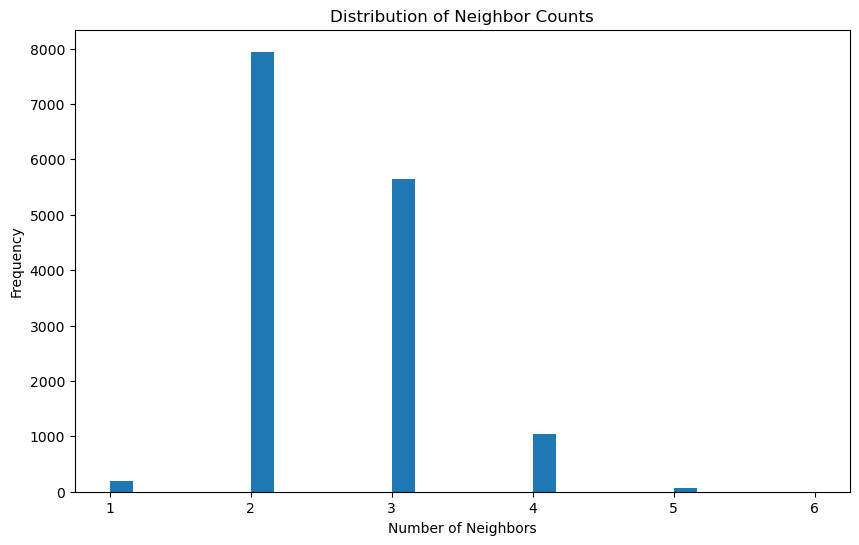

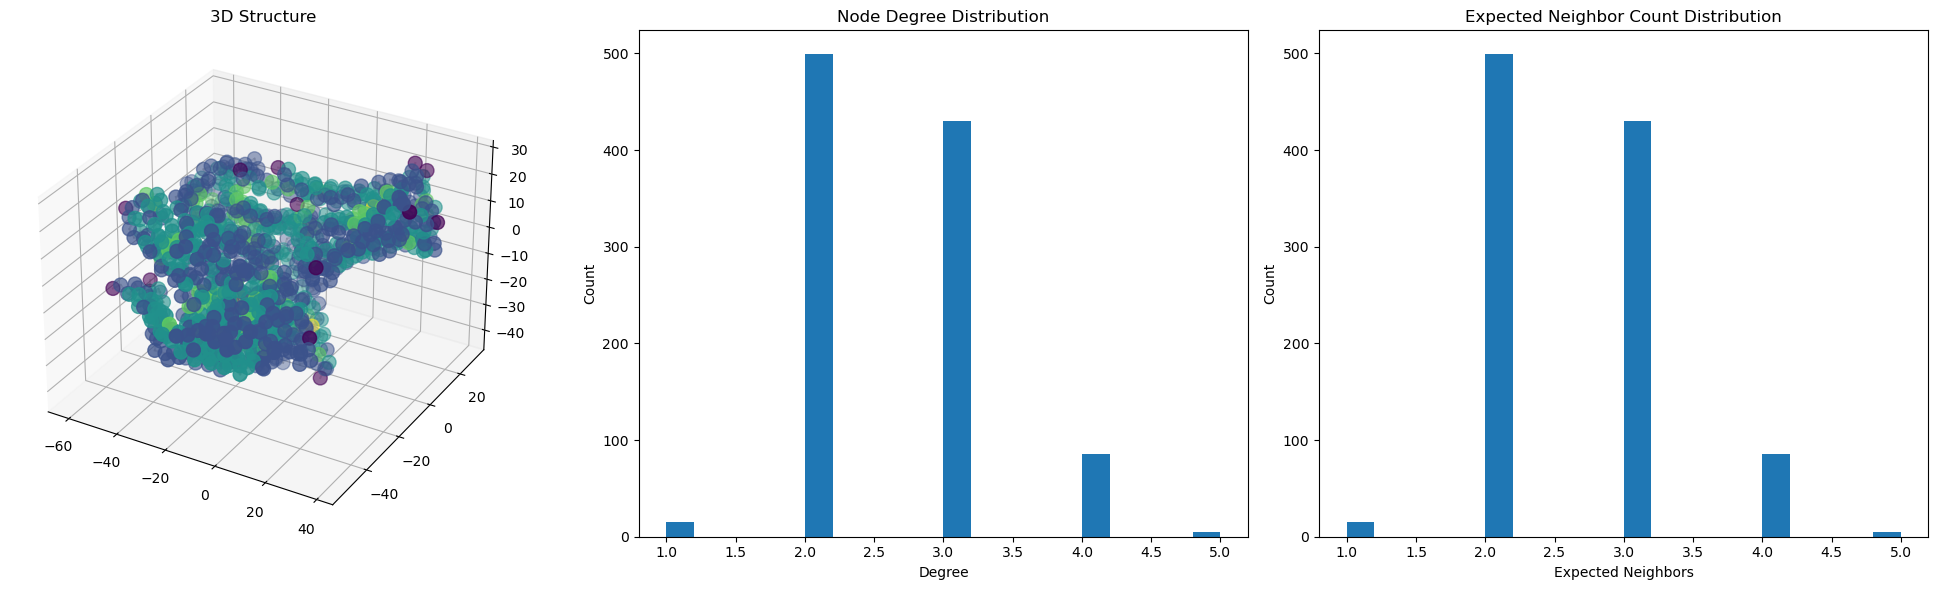


Graph 0 Statistics:
Number of nodes: 1035
Number of edges: 5344
Average neighbor count: 2.58
Average degree: 2.58

No validation issues found.


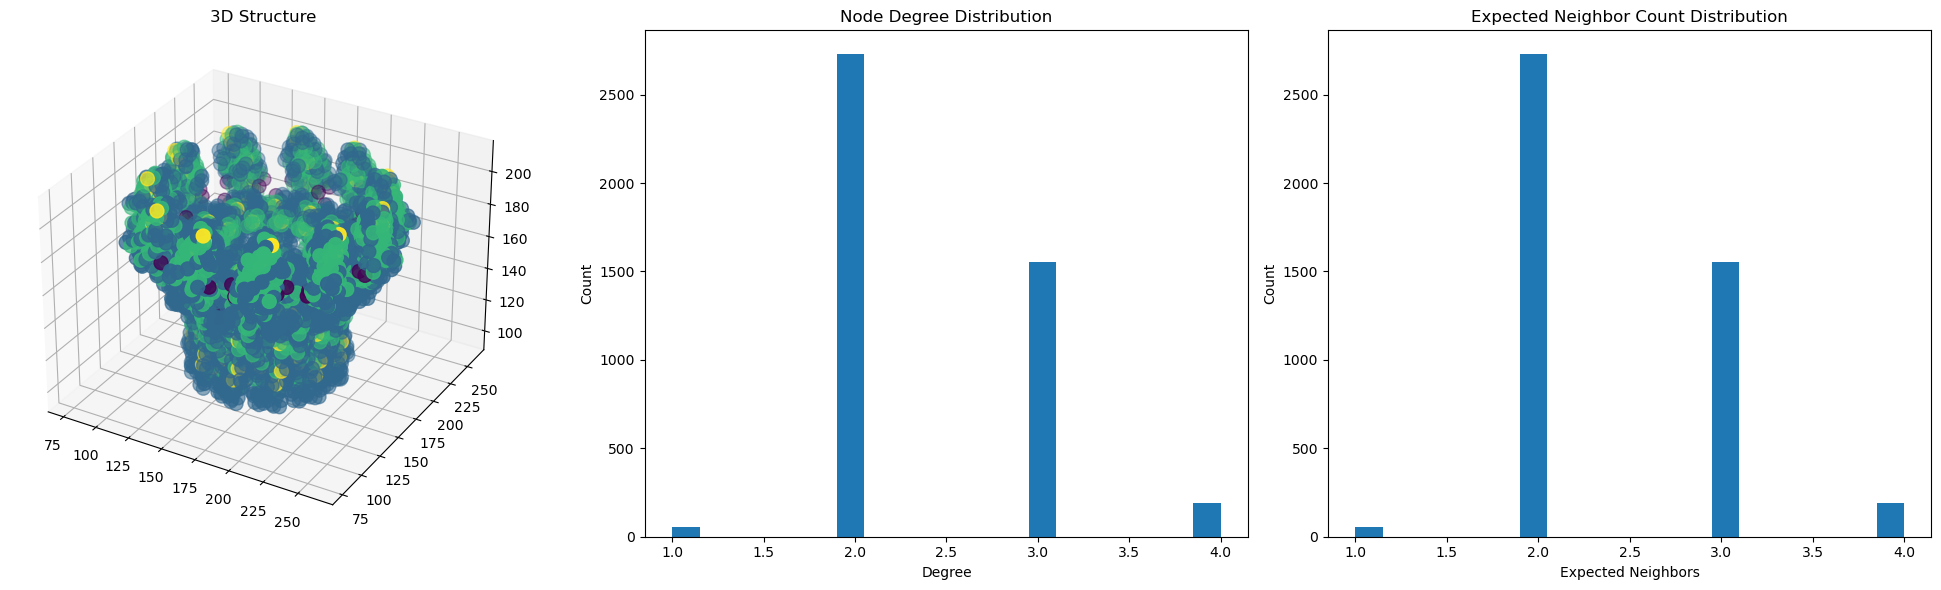


Graph 1 Statistics:
Number of nodes: 4521
Number of edges: 21828
Average neighbor count: 2.41
Average degree: 2.41

No validation issues found.


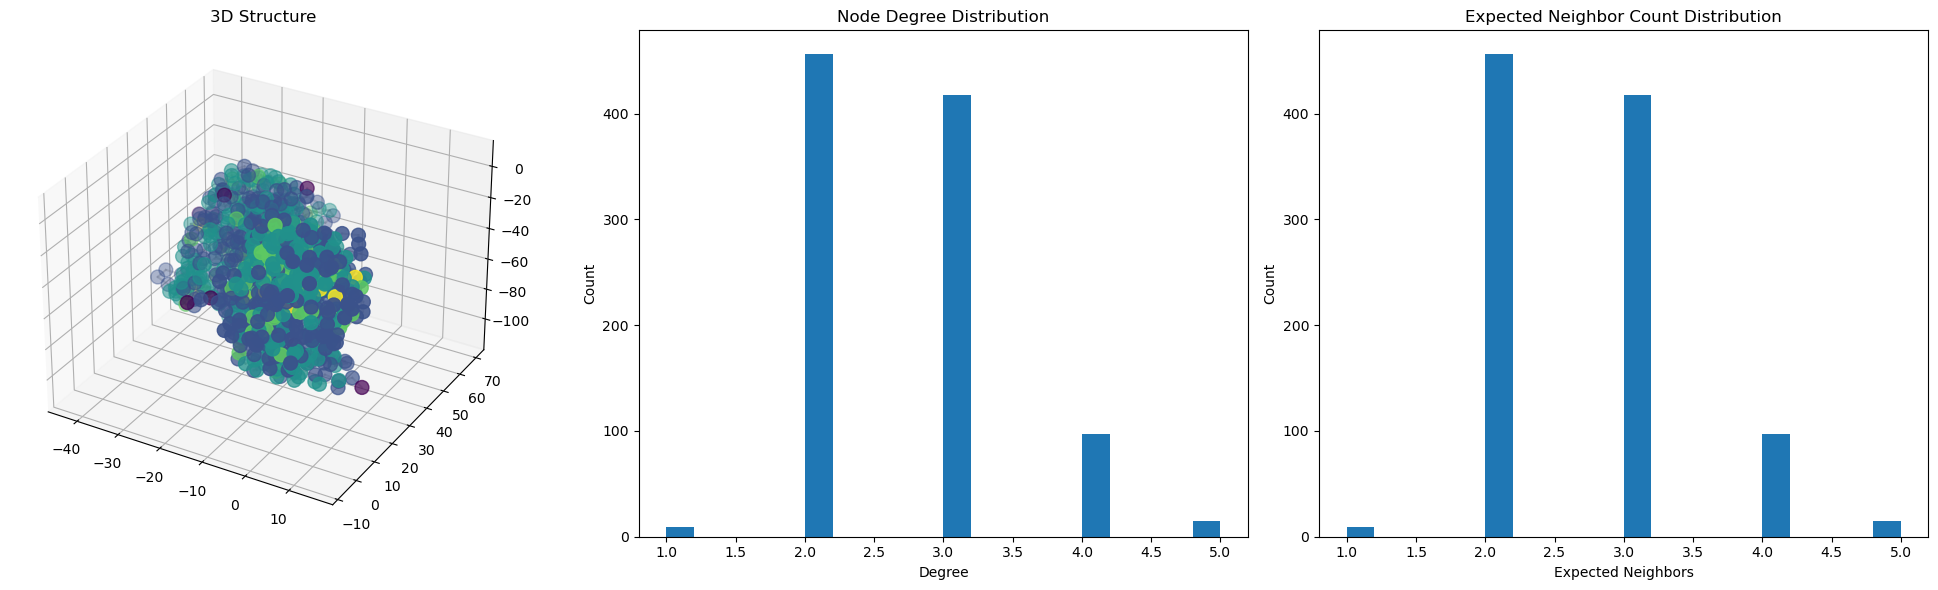

INFO:__main__:Split dataset into 8 training and 3 validation graphs
INFO:__main__:
Training set statistics:
INFO:__main__:Average nodes: 1420.50
INFO:__main__:Average edges: 7107.00
INFO:__main__:Average neighbors: 2.54
INFO:__main__:
Validation set statistics:
INFO:__main__:Average nodes: 1176.00
INFO:__main__:Average edges: 6066.67
INFO:__main__:Average neighbors: 2.59
INFO:__main__:
Created data loaders with batch size 32
INFO:__main__:Training batches: 1
INFO:__main__:Validation batches: 1
INFO:__main__:
Batch structure:
INFO:__main__:Batch size: 8
INFO:__main__:Total nodes: 11364
INFO:__main__:Total edges: 56856
INFO:__main__:Feature dimension: 3



Graph 2 Statistics:
Number of nodes: 995
Number of edges: 5276
Average neighbor count: 2.65
Average degree: 2.65

No validation issues found.


In [25]:
# Create graphs with validation
from tqdm import tqdm

graphs = create_graphs_from_df_array(autoencoder_input_dfs)

# Validate first few graphs
for i in range(min(3, len(graphs))):
    visualize_protein_graph(graphs[i], i)

# If graphs look good, proceed with splitting and loader creation
train_graphs, val_graphs = split_dataset(graphs)
train_loader, val_loader = create_data_loaders(train_graphs, val_graphs)